In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openfermion as of
from itertools import product
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy as sp
from pyscf import gto, scf, ao2mo, mp, tdscf, dft
from pyscf import sftda
from openfermionpyscf import generate_molecular_hamiltonian
import glob

## Generalized Hartree-Fock

In [2]:
mol = gto.M(
    atom = 'H 0 0 0; H 0 0 0.7414',
    basis = '6-31G',
    spin = 0,
    charge = 0
)

mf = dft.UKS(mol)
mf.xc = 'svwn'
mf.kernel()

mo_coeff = mf.mo_coeff
# print("MO Coefficients:\n", mo_coeff)

multiplicity = 1
molecular_hamiltonian = generate_molecular_hamiltonian(
    mol.atom, mol.basis, multiplicity, mol.charge
)

jw_hamiltonian = of.jordan_wigner(of.get_fermion_operator(molecular_hamiltonian))
# print("JW Hamiltonian:\n", jw_hamiltonian)

n_qubits = mol.nao * 2

converged SCF energy = -1.1326863696955  <S^2> = 8.8817842e-16  2S+1 = 1


In [3]:
n_electron = 2
n_excited_state = 12
# p = n_excited_state + 1
p = n_excited_state

valid_indices = []
for bits in product('01', repeat= n_qubits):
    if bits.count('1') == n_electron:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))
        # print(int(binary_str,2))

In [4]:
sparse_hamiltonian = of.get_sparse_operator(jw_hamiltonian)
H = sparse_hamiltonian[np.ix_(valid_indices, valid_indices)].toarray()
H_eigvals, H_eigvecs = sp.linalg.eigh(H)
print(f"H4 eigenvalues", H_eigvals[:])
H_dim = len(H)
print(H_dim)

H4 eigenvalues [-1.15168273 -0.75773024 -0.75773024 -0.75773024 -0.5895212  -0.29138606
 -0.29138606 -0.29138606 -0.10417604 -0.04246383  0.21991574  0.21991574
  0.21991574  0.26493721  0.32503348  0.32503348  0.32503348  0.60682782
  0.75746316  0.75746316  0.75746316  0.81859995  0.95212274  1.19906376
  1.19906376  1.19906376  1.4664651   1.92414548]
28


In [5]:
mftd = mf.TDA()
mftd.nstates = n_excited_state//2-1 # -1 for length>3....only for H2!!!
mftd.kernel()

Excited State energies (eV)
[11.03211364 14.78792114 23.54929036 28.63828359 36.85150548]


(array([0.4054227 , 0.54344608, 0.86542047, 1.05243752, 1.35426786]),
 [((array([[7.06525961e-01, 1.97985604e-16, 2.86543279e-02]]),
    array([[-7.06525955e-01, -8.01692124e-17, -2.86543285e-02]])),
   (0, 0)),
  ((array([[-7.02574351e-01,  2.04610700e-16,  7.99329549e-02]]),
    array([[-7.02574357e-01,  2.12685626e-16,  7.99329547e-02]])),
   (0, 0)),
  ((array([[ 9.88771848e-17, -7.07106782e-01, -3.08708546e-16]]),
    array([[-1.64368302e-16,  7.07106781e-01,  1.13094840e-16]])),
   (0, 0)),
  ((array([[ 6.35229988e-17, -7.07106781e-01, -6.71658226e-17]]),
    array([[ 1.64130977e-18, -7.07106782e-01,  1.74022329e-16]])),
   (0, 0)),
  ((array([[-2.86543283e-02, -2.87570575e-16,  7.06525957e-01]]),
    array([[ 2.86543281e-02,  1.38953659e-16, -7.06525959e-01]])),
   (0, 0))])

In [6]:
mftd_sf_up = sftda.TDA_SF(mf)
mftd_sf_up.nstates = n_excited_state//4 # the number of excited states
mftd_sf_up.extype = 0 # 0 for spin flip up excited energies
# the spin sample points in multicollinear approach, which
# can be increased by users.
mftd_sf_up.collinear_samples=1
mftd_sf_up.max_space  = 1
mftd_sf_up.kernel()

#
# 2. spin flip down TDA
#
mftd_sf_dn = sftda.uks_sf.TDA_SF(mf)
mftd_sf_dn.nstates = n_excited_state//4 # the number of excited states
mftd_sf_dn.extype = 1 # 1 for spin flip down excited energies
mftd_sf_dn.collinear_samples=1
mftd_sf_dn.max_space  = 1
mftd_sf_dn.kernel()

1


<class 'pyscf.sftda.uhf_sf.TDA_SF'> does not have attributes  max_space


Excited State energies (eV)
[11.03211365 23.54929037 36.85150551]
1


<class 'pyscf.sftda.uks_sf.TDA_SF'> does not have attributes  max_space


Excited State energies (eV)
[11.03211363 23.54929034 36.85150545]


(array([0.4054227 , 0.86542046, 1.35426786]),
 [((0, array([[9.99178592e-01, 4.49899446e-17, 4.05233396e-02]])), (0, 0)),
  ((0, array([[ 0.00000000e+00, -1.00000000e+00,  9.99200722e-16]])), (0, 0)),
  ((0, array([[ 4.05233396e-02, -1.10931108e-15, -9.99178592e-01]])), (0, 0))])

In [7]:
def sf_up_state(ith, valid_indices, xy, n_electron, n_qubits):
    HF_index = 0
    for i in range(n_electron):
        HF_index += 2**(n_qubits-i-1)

    X_spin_up = xy[ith][0][0]

    n_occ_state = n_electron//2 # only can do the even case
    n_vir_state = n_qubits//2 - n_occ_state

    state= np.zeros(2**n_qubits)
    for occ_index in range(n_occ_state):
        for vir_index in range(n_vir_state):
                spin_up_excited_state = np.zeros(2**n_qubits)

                spin_up_excited_index = HF_index - 2**(n_qubits-occ_index*2-1) + 2**(n_qubits-2-n_electron-vir_index*2)

                spin_up_excited_state[spin_up_excited_index] = 1

                state += X_spin_up[occ_index][vir_index] * spin_up_excited_state

    state = state[valid_indices]
    
    return state

In [8]:
def sf_dn_state(ith, valid_indices, xy, n_electron, n_qubits):
    HF_index = 0
    for i in range(n_electron):
        HF_index += 2**(n_qubits-i-1)

    X_spin_dn = xy[ith][0][1] # tdhf.xy[excited_state_index][X_or_Y][spin][occupied_MO][virtual_MO]

    n_occ_state = n_electron//2 # only can do the even case
    n_vir_state = n_qubits//2 - n_occ_state

    state= np.zeros(2**n_qubits)
    for occ_index in range(n_occ_state):
        for vir_index in range(n_vir_state):
                spin_dn_excited_state = np.zeros(2**n_qubits)

                spin_dn_excited_index = HF_index - 2**(n_qubits-occ_index*2-2) + 2**(n_qubits-1-n_electron-vir_index*2)

                spin_dn_excited_state[spin_dn_excited_index] = 1

                state += X_spin_dn[occ_index][vir_index] * spin_dn_excited_state

    state = state[valid_indices]
    
    return state

In [9]:
def spin_conserved_state(ith, valid_indices, xy, n_electron, n_qubits):
    # HF_state = np.zeros(2**n_qubits)
    HF_index = 0
    for i in range(n_electron):
        HF_index += 2**(n_qubits-i-1)
    # HF_state[HF_index] = 1

    # HF_state = HF_state[valid_indices]
    X_spin_up = xy[ith][0][0] # tdhf.xy[excited_state_index][X_or_Y][spin][occupied_MO][virtual_MO]
    X_spin_dn = xy[ith][0][1]

    n_occ_state = n_electron//2 # only can do the even case
    n_vir_state = n_qubits//2 - n_occ_state

    state= np.zeros(2**n_qubits)
    for occ_index in range(n_occ_state):
        for vir_index in range(n_vir_state):
                spin_up_excited_state = np.zeros(2**n_qubits)
                spin_dn_excited_state = np.zeros(2**n_qubits)

                spin_up_excited_index = HF_index - 2**(n_qubits-occ_index*2-1) + 2**(n_qubits-1-n_electron-vir_index*2)
                spin_dn_excited_index = HF_index - 2**(n_qubits-occ_index*2-2) + 2**(n_qubits-2-n_electron-vir_index*2)

                # print(occ_index, vir_index)
                # print(spin_up_excited_index)
                # print(spin_dn_excited_index)

                spin_up_excited_state[spin_up_excited_index] = 1
                spin_dn_excited_state[spin_dn_excited_index] = 1

                state += X_spin_up[occ_index][vir_index] * spin_up_excited_state + X_spin_dn[occ_index][vir_index] * spin_dn_excited_state

    state = state[valid_indices]
    # state = state/sp.linalg.norm(state)
    
    return state

def TDA_states_solver(n_excited_state, valid_indices, n_electron, n_qubits, mf, td, td_sf_up, td_sf_dn):

    # Notice!! The order of eigvals and eigvecs are not consistent!

    eigvecs = []

    HF_state = np.zeros(2**n_qubits)
    HF_index = 0
    for i in range(n_electron):
        HF_index += 2**(n_qubits-i-1)
    HF_state[HF_index] = 1
    HF_state = HF_state[valid_indices]

    eigvecs.append(HF_state)
    for i in range(n_excited_state//2-1): # -1 for length>3....only for H2!!!
        eigvecs.append(spin_conserved_state(i, valid_indices, td.xy, n_electron, n_qubits))

    eigvals = [mf.energy_tot()]
    for excited_energy in td.e:
        eigvals.append(mf.energy_tot() + excited_energy)

    for i in range(n_excited_state//4):
        eigvecs.append(sf_up_state(i, valid_indices, td_sf_up.xy, n_electron, n_qubits))

    for excited_energy in td_sf_up.e:
        eigvals.append(mf.energy_tot() + excited_energy)

    for i in range(n_excited_state//4):
        eigvecs.append(sf_dn_state(i, valid_indices, td_sf_dn.xy, n_electron, n_qubits))
    eigvecs = np.array(eigvecs).T

    for excited_energy in td_sf_dn.e:
        eigvals.append(mf.energy_tot() + excited_energy)
    
    eigvals = np.sort(eigvals)
    return eigvals, eigvecs


In [10]:
TDA_eigvals, TDA_eigvecs = TDA_states_solver(n_excited_state, valid_indices, n_electron, n_qubits, mf, mftd, mftd_sf_up, mftd_sf_dn)

In [11]:
TDA_eigvals

array([-1.13268637, -0.72726367, -0.72726367, -0.72726367, -0.58924029,
       -0.2672659 , -0.2672659 , -0.2672659 , -0.08024885,  0.22158149,
        0.22158149,  0.22158149])

In [12]:
H_eigvals[:p]

array([-1.15168273, -0.75773024, -0.75773024, -0.75773024, -0.5895212 ,
       -0.29138606, -0.29138606, -0.29138606, -0.10417604, -0.04246383,
        0.21991574,  0.21991574])

In [13]:
np.shape(TDA_eigvecs)

(28, 12)

In [14]:
def gram_schmidt(vectors):
    """
    使用 Gram-Schmidt 過程將一組向量正交化。
    :param vectors: shape (n, m) 的 numpy array，n 是向量數量，m 是維度
    :return: 正交化後的向量矩陣
    """
    orthogonal_vectors = []
    for v in vectors.T:
        w = v.copy()
        for u in orthogonal_vectors:
            w -= np.dot(u, v) / np.dot(u, u) * u
        if np.linalg.norm(w) > 1e-10:  # 避免數值誤差導致零向量
            orthogonal_vectors.append(w / np.linalg.norm(w))
    return np.array(orthogonal_vectors).T

TDA_eigvecs = gram_schmidt(TDA_eigvecs)

In [15]:
np.shape(TDA_eigvecs)

(28, 12)

In [16]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = np.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = np.zeros((dim, dim), dtype=np.complex64)
    for d in range(degeneracy_dim):
        O += np.outer(degeneracy_eigvecs[:, d], np.conj(degeneracy_eigvecs[:, d]))
    Q = np.eye(dim) - O
    M = alpha * O + Q @ (E * np.eye(dim) - H) @ Q + gamma * 1j * np.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = sp.linalg.inv(M)

    Rij = np.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return np.real(Hij + Rij - E * np.eye(degeneracy_dim))

In [17]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = np.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = np.zeros((dim, dim), dtype=np.complex64)
    for d in range(degeneracy_dim):
        O += np.outer(degeneracy_eigvecs[:, d], np.conj(degeneracy_eigvecs[:, d]))
    Q = np.eye(dim) - O
    M = alpha * O + Q @ (E * np.eye(dim) - H) @ Q + gamma * 1j * np.eye(dim)

    N = sp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = sp.linalg.eigh(M)
    M_eigvals_inv = np.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ np.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = np.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return np.real(Hij + Rij - E * np.eye(degeneracy_dim))

In [18]:
def Schur_complement_norm(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = np.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = np.zeros((dim, dim), dtype=np.complex64)
    for d in range(degeneracy_dim):
        O += np.outer(degeneracy_eigvecs[:, d], np.conj(degeneracy_eigvecs[:, d]))
    Q = np.eye(dim) - O
    M = alpha * O + Q @ (E * np.eye(dim) - H) @ Q + gamma * 1j * np.eye(dim)

    N = sp.linalg.norm(M)

    return(N)

In [19]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = np.zeros((dim, dim), dtype=np.complex64)
    for d in range(degeneracy_dim):
        O += np.outer(degeneracy_eigvecs[:, d], np.conj(degeneracy_eigvecs[:, d]))
    Q = np.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = sp.linalg.eigh(QHQ)

    return spectrum

In [20]:
degeneracy_idx = [0, p-1]
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H, init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim)

## Eigenbranches (error $ = 10^{-8}$)

In [21]:
kappa = 400
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = np.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [22]:
Xlim = [-1.25, 0]
N_plot = 10000
Energy = np.linspace(Xlim[0], Xlim[1], N_plot)

In [23]:
Schur_complement_norm(H=H, E=H_eigvals[0], init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim)

8.691443640711237

In [24]:
Eigenbranches = []
for i, En in enumerate(Energy):
    if i % 10 == 0:
        print('iter', i)
    Schur = Schur_complement_qsp(H=H, E=En, init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim, poly=poly, kappa=kappa)
    sub_eigvals = sp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = np.array(Eigenbranches).T

iter 0
iter 10
iter 20
iter 30
iter 40
iter 50
iter 60
iter 70
iter 80
iter 90
iter 100
iter 110
iter 120
iter 130
iter 140
iter 150
iter 160
iter 170
iter 180
iter 190
iter 200
iter 210
iter 220
iter 230
iter 240
iter 250
iter 260
iter 270
iter 280
iter 290
iter 300
iter 310
iter 320
iter 330
iter 340
iter 350
iter 360
iter 370
iter 380
iter 390
iter 400
iter 410
iter 420
iter 430
iter 440
iter 450
iter 460
iter 470
iter 480
iter 490
iter 500
iter 510
iter 520
iter 530
iter 540
iter 550
iter 560
iter 570
iter 580
iter 590
iter 600
iter 610
iter 620
iter 630
iter 640
iter 650
iter 660
iter 670
iter 680
iter 690
iter 700
iter 710
iter 720
iter 730
iter 740
iter 750
iter 760
iter 770
iter 780
iter 790
iter 800
iter 810
iter 820
iter 830
iter 840
iter 850
iter 860
iter 870
iter 880
iter 890
iter 900
iter 910
iter 920
iter 930
iter 940
iter 950
iter 960
iter 970
iter 980
iter 990
iter 1000
iter 1010
iter 1020
iter 1030
iter 1040
iter 1050
iter 1060
iter 1070
iter 1080
iter 1090
iter 1100
i

In [25]:
ED_Eigenbranches = []
for i, En in enumerate(Energy):
    if i % 10 == 0:
        print('iter', i)
    Schur = Schur_complement(H=H, E=En, init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim)
    sub_eigvals = sp.linalg.eigvalsh(Schur)
    ED_Eigenbranches.append(sub_eigvals)
ED_Eigenbranches = np.array(ED_Eigenbranches).T

iter 0
iter 10
iter 20
iter 30
iter 40
iter 50
iter 60
iter 70
iter 80
iter 90
iter 100
iter 110
iter 120
iter 130
iter 140
iter 150
iter 160
iter 170
iter 180
iter 190
iter 200
iter 210
iter 220
iter 230
iter 240
iter 250
iter 260
iter 270
iter 280
iter 290
iter 300
iter 310
iter 320
iter 330
iter 340
iter 350
iter 360
iter 370
iter 380
iter 390
iter 400
iter 410
iter 420
iter 430
iter 440
iter 450
iter 460
iter 470
iter 480
iter 490
iter 500
iter 510
iter 520
iter 530
iter 540
iter 550
iter 560
iter 570
iter 580
iter 590
iter 600
iter 610
iter 620
iter 630
iter 640
iter 650
iter 660
iter 670
iter 680
iter 690
iter 700
iter 710
iter 720
iter 730
iter 740
iter 750
iter 760
iter 770
iter 780
iter 790
iter 800
iter 810
iter 820
iter 830
iter 840
iter 850
iter 860
iter 870
iter 880
iter 890
iter 900
iter 910
iter 920
iter 930
iter 940
iter 950
iter 960
iter 970
iter 980
iter 990
iter 1000
iter 1010
iter 1020
iter 1030
iter 1040
iter 1050
iter 1060
iter 1070
iter 1080
iter 1090
iter 1100
i

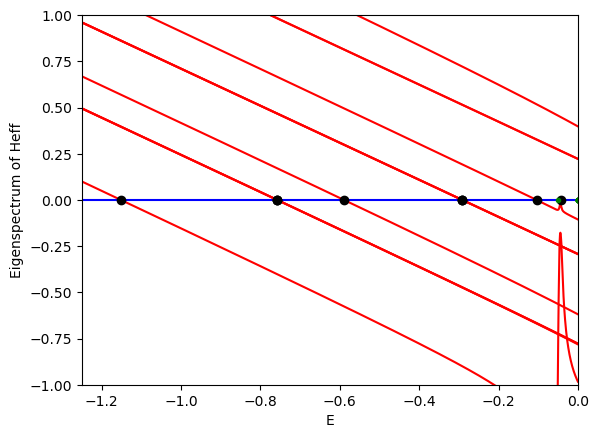

In [26]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(-8, -7.6)
plt.ylim(-1, 1)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

# for ED_Eigenbranch in ED_Eigenbranches:
#     plt.plot(Energy, ED_Eigenbranch, 'black', linestyle='--', lw=0.7)

plt.axhline(y=0, color='blue')

plt.plot(H_eigvals, np.zeros_like(H_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, np.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

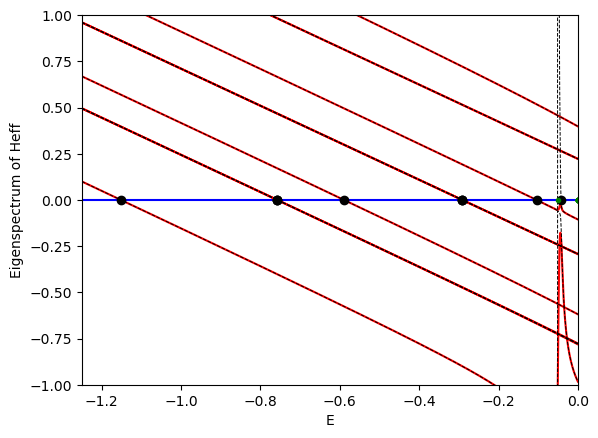

In [27]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(-8, -7.6)
plt.ylim(-1, 1)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

for ED_Eigenbranch in ED_Eigenbranches:
    plt.plot(Energy, ED_Eigenbranch, 'black', linestyle='--', lw=0.7)

plt.axhline(y=0, color='blue')

plt.plot(H_eigvals, np.zeros_like(H_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, np.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

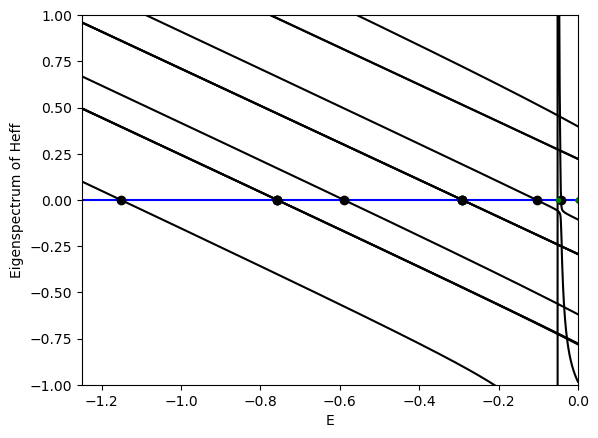

In [28]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(-8, -7.6)
plt.ylim(-1, 1)

# for Eigenbranch in Eigenbranches:
#     plt.plot(Energy, Eigenbranch, 'red')

for ED_Eigenbranch in ED_Eigenbranches:
    plt.plot(Energy, ED_Eigenbranch, 'black')

plt.axhline(y=0, color='blue')

plt.plot(H_eigvals, np.zeros_like(H_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, np.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

### vs TDA

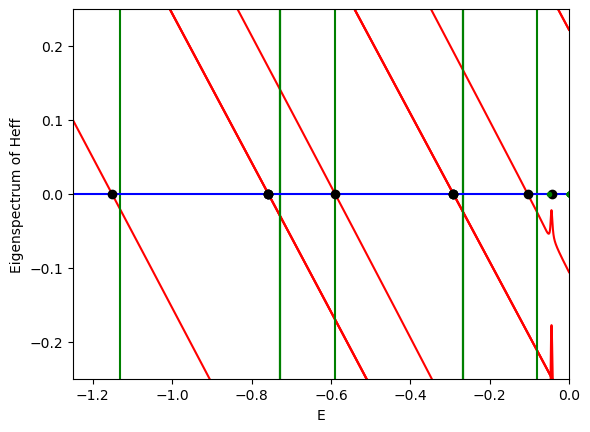

In [29]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(-2.25, -1.25)
plt.ylim(-0.25, 0.25)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

for Prepared_eigval in TDA_eigvals:
    plt.axvline(x=Prepared_eigval, color='green')
plt.axhline(y=0, color='blue')

plt.plot(H_eigvals, np.zeros_like(H_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, np.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

## Generalized Hartree-Fock

In [30]:
mf = scf.GHF(mol)
ehf = mf.kernel()

converged SCF energy = -1.1267339671166  <S^2> = 5.9396932e-15  2S+1 = 1


## GCCSD

In [31]:
mycc = mf.CCSD()
ecc, t1, t2 = mycc.kernel()

E(GCCSD) = -1.15168273585941  E_corr = -0.0249487687428095


## EOM-GCCSD and excited states

In [32]:
eom_e, eom_v = mycc.eeccsd(nroots=n_excited_state)

In [33]:
CCSD_eigvals = [ehf + ecc]
for e in eom_e:
    CCSD_eigvals.append(ehf + ecc + e)

In [35]:
print("E_CCSD - E_exact:\n", CCSD_eigvals-H_eigvals[:13])

E_CCSD - E_exact:
 [-3.74952247e-09 -4.64171590e-10 -4.64169037e-10 -4.64167038e-10
 -7.43834105e-10  9.99200722e-16  8.88178420e-16 -1.88737914e-15
 -5.84738702e-10  2.47043075e-09 -5.24737420e-10 -5.20159249e-10
 -5.15601228e-10]


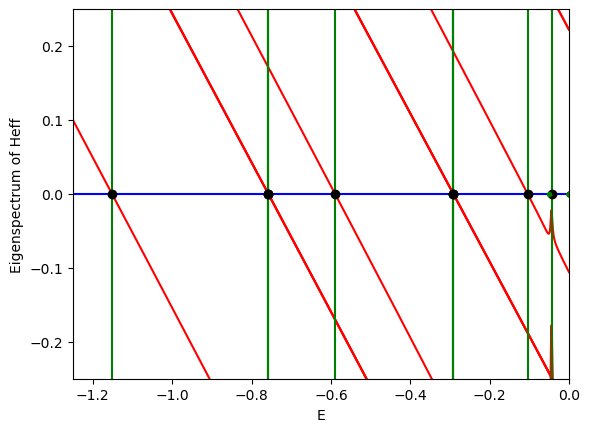

In [36]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(-2.25, -1.25)
plt.ylim(-0.25, 0.25)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

for Prepared_eigval in CCSD_eigvals:
    plt.axvline(x=Prepared_eigval, color='green')
plt.axhline(y=0, color='blue')

plt.plot(H_eigvals, np.zeros_like(H_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, np.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

## Binary search

In [37]:
def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = np.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if np.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()

solved_eigvals = []
for subspace_eigvals_idx in range(p):
    subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim, poly=poly, kappa=kappa), 
                                            x0=TDA_eigvals, subspace_eigvals_idx=subspace_eigvals_idx)
    solved_eigvals.append(subspace_solved_eigval)

Converged in 20 iterations.
-1.1516827268946543
Converged in 21 iterations.
-0.7577302414521181
Converged in 21 iterations.
-0.7577302405776365
Converged in 21 iterations.
-0.7577302405776356
Converged in 14 iterations.
-0.5895211983024132
Converged in 21 iterations.
-0.29138605817309593
Converged in 21 iterations.
-0.2913860581730957
Converged in 21 iterations.
-0.29138605817309526
Converged in 20 iterations.
-0.10417603355092783
Converged in 16 iterations.
0.21991575231637475
Converged in 16 iterations.
0.21991575231638222
Converged in 8 iterations.
0.264937247440164


In [38]:
print("E_QSVT - E_exact:\n", solved_eigvals-H_eigvals[:p])

E_QSVT - E_exact:
 [5.21523313e-09 2.71705713e-09 3.59153651e-09 3.59153396e-09
 6.13309215e-09 6.59141197e-09 6.59141186e-09 6.59140920e-09
 1.10644065e-08 2.62379586e-01 1.18034427e-08 4.50215069e-02]


In [40]:
print("E_CCSD - E_exact:\n", CCSD_eigvals-H_eigvals[:13])

E_CCSD - E_exact:
 [-3.74952247e-09 -4.64171590e-10 -4.64169037e-10 -4.64167038e-10
 -7.43834105e-10  9.99200722e-16  8.88178420e-16 -1.88737914e-15
 -5.84738702e-10  2.47043075e-09 -5.24737420e-10 -5.20159249e-10
 -5.15601228e-10]


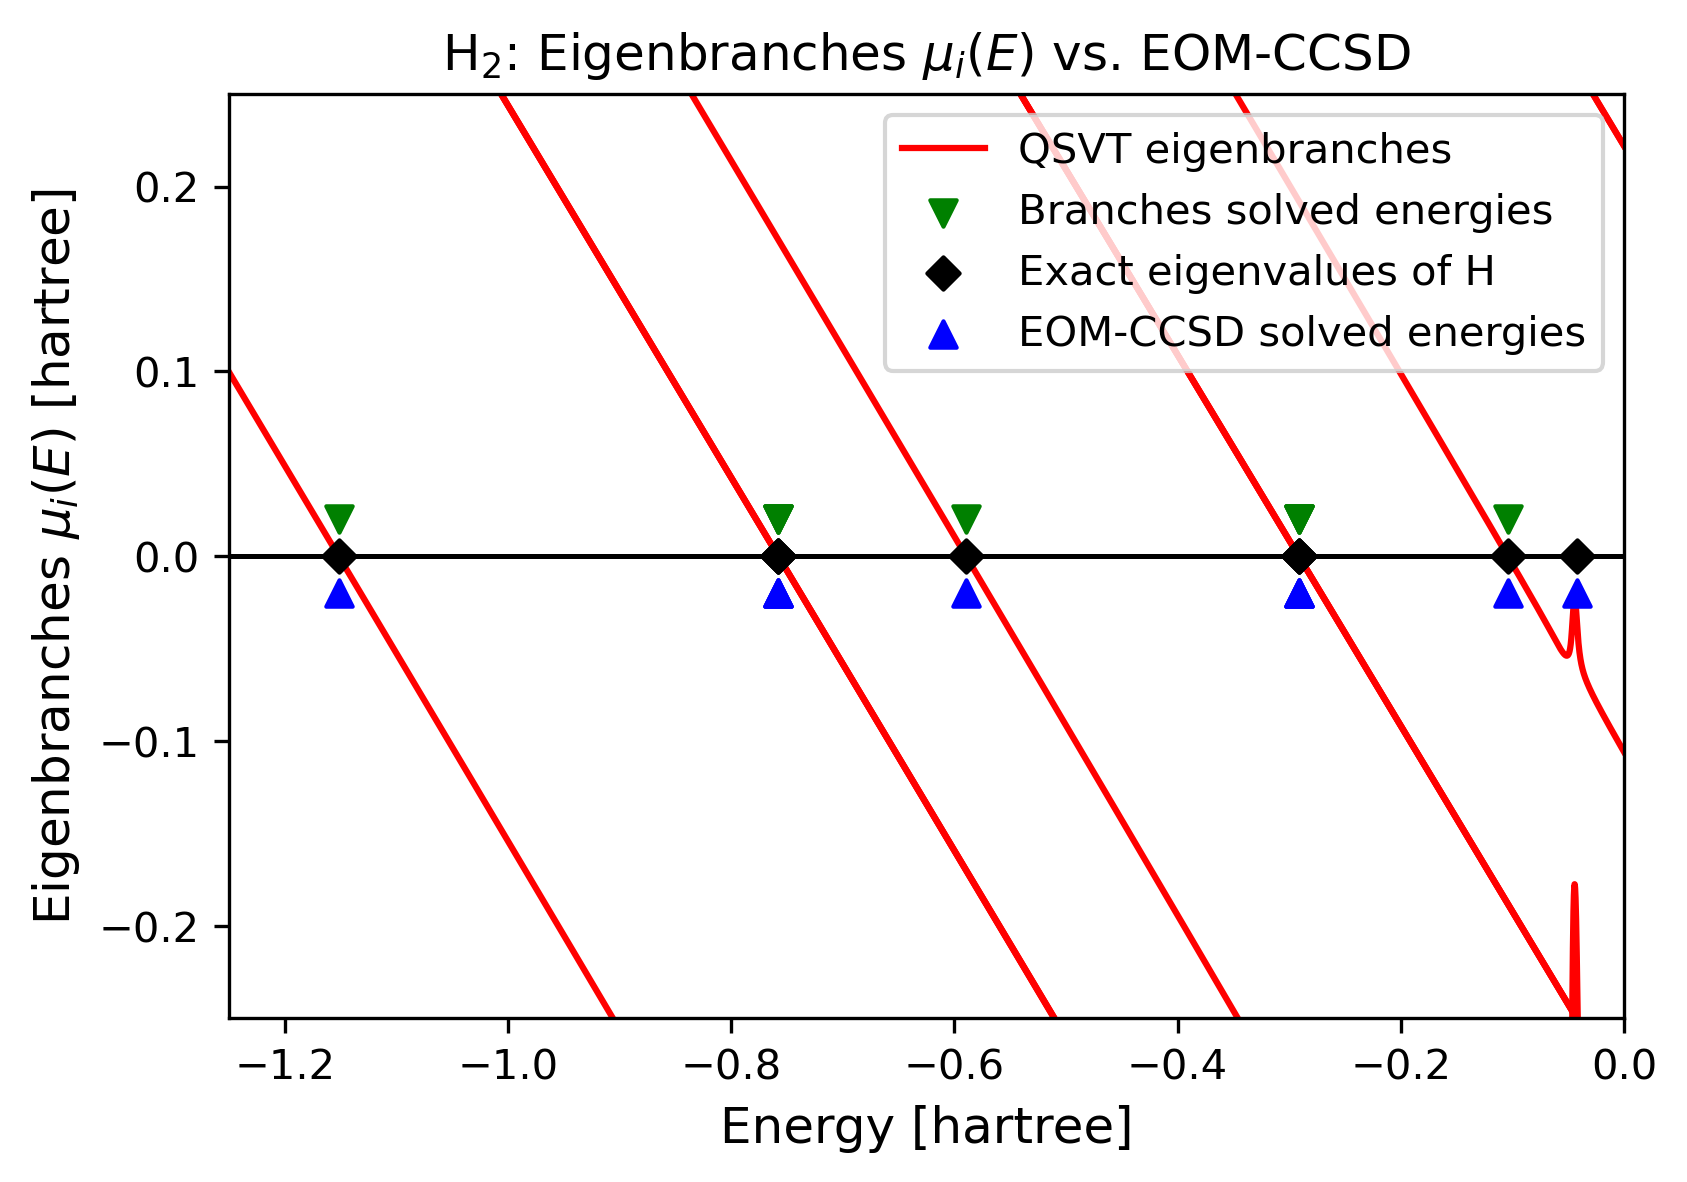

In [41]:
# 畫圖
plt.figure(figsize=(6, 4), dpi=300)  # 設定尺寸與解析度
plt.xlabel('Energy [hartree]', fontsize=12)
plt.ylabel(r'Eigenbranches $\mu_i(E)$ [hartree]', fontsize=12)
plt.xlim(-1.25, 0)
plt.ylim(-0.25, 0.25)

# 畫基準線
plt.axhline(y=0, color='black', linewidth=1.2)

# 畫 Eigenbranches
for i, Eigenbranch in enumerate(Eigenbranches):
    if(i==0):
        plt.plot(Energy, Eigenbranch, color='red', linewidth=1.5, label='QSVT eigenbranches')
    else:
        plt.plot(Energy, Eigenbranch, color='red', linewidth=1.5)

# 用散點標示結果 (三角形)
plt.scatter(solved_eigvals, np.zeros_like(solved_eigvals) + 0.02,  # 稍微上移 0.02 避免重疊
            color='green', marker='v', s=40, label='Branches solved energies', zorder=3)

# 畫本徵值
plt.scatter(H_eigvals, np.zeros_like(H_eigvals), color='black', marker='D', s=30, label='Exact eigenvalues of H', zorder=4)

plt.scatter(CCSD_eigvals, np.zeros_like(CCSD_eigvals) - 0.02,  # 稍微上移 0.02 避免重疊
            color='blue', marker='^', s=40, label='EOM-CCSD solved energies', zorder=2)

# plt.plot(QHQ_eigvals, np.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3, label='Eigenvalues of QHQ')
# 加入圖例
plt.legend(fontsize=10, loc='upper right', frameon=True)


plt.title(r'H$_2$: Eigenbranches $\mu_i(E)$ vs. EOM-CCSD')

# 儲存高解析度圖片
plt.savefig('H2_eigenbranches.png', dpi=300, bbox_inches='tight')
# 顯示圖表
plt.show()


# Binary search 

In [42]:
len_sweep = np.linspace(0.1, 4., 101)

In [45]:
solved_eigvals = []

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = np.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if np.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, L in enumerate(len_sweep):
    # Skip the first iteration
    print('solve:', i)
    
    mol = gto.M(
    atom = f'H 0 0 0; H 0 0 {L}',
    basis = '6-31G',
    spin = 0,
    charge = 0
    )

    mf = dft.UKS(mol)
    mf.xc = 'svwn'
    mf.kernel()

    mftd = mf.TDA()
    mftd.nstates = n_excited_state//2-1 # -1 for length>3....only for H2!!!
    mftd.kernel()

    mftd_sf_up = sftda.TDA_SF(mf)
    mftd_sf_up.nstates = n_excited_state//4 # the number of excited states
    mftd_sf_up.extype = 0 # 0 for spin flip up excited energies
    mftd_sf_up.collinear_samples=1
    mftd_sf_up.max_space  = 1
    mftd_sf_up.kernel()


    mftd_sf_dn = sftda.uks_sf.TDA_SF(mf)
    mftd_sf_dn.nstates = n_excited_state//4 # the number of excited states
    mftd_sf_dn.extype = 1 # 1 for spin flip down excited energies
    mftd_sf_dn.collinear_samples=1
    mftd_sf_dn.max_space  = 1
    mftd_sf_dn.kernel()

    TDA_eigvals, TDA_eigvecs = TDA_states_solver(n_excited_state, valid_indices, n_electron, n_qubits, mf, mftd, mftd_sf_up, mftd_sf_dn)
    
    multiplicity = 1
    molecular_hamiltonian = generate_molecular_hamiltonian(
        mol.atom, mol.basis, multiplicity, mol.charge
    )

    jw_hamiltonian = of.jordan_wigner(of.get_fermion_operator(molecular_hamiltonian))
    sparse_hamiltonian = of.get_sparse_operator(jw_hamiltonian)
    H = sparse_hamiltonian[np.ix_(valid_indices, valid_indices)].toarray()
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(12):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=TDA_eigvecs, degeneracy_idx=degeneracy_idx, dim=H_dim, poly=poly, kappa=kappa), 
                                                x0=TDA_eigvals, subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = np.real(np.array(solved_eigvals).T)

solve: 0
converged SCF energy = 2.60973364004578  <S^2> = -8.8817842e-16  2S+1 = 1


Excited State energies (eV)
[20.31270411 21.33724897 23.10800779 28.10274705 97.69548781]
1
Excited State energies (eV)
[20.31270411 23.10800781 97.69548785]
1
Excited State energies (eV)
[20.3127041  23.10800778 97.69548778]
Converged in 21 iterations.
2.5710887681451218
Converged in 19 iterations.
3.3662561010472327
Converged in 19 iterations.
3.366256105406894
Converged in 19 iterations.
3.3662561054361775
Converged in 19 iterations.
3.4095792186155878
Converged in 20 iterations.
3.438774122463993
Converged in 20 iterations.
3.4387741224639945
Converged in 20 iterations.
3.4387741224639954
Converged in 21 iterations.
3.600488369693834
Converged in 22 iterations.
6.136189570783092
Converged in 22 iterations.
6.136189570783097
Converged in 24 iterations.
6.501291012491086
solve: 1
converged SCF energy = 1.17429674734124  <S^2> = -4.4408921e-16  2S+1 = 1
Excited State energies (eV)
[19.84376044 20.94396978 22.96800145 28.11099409 91.12530842]
1
Excited State energies (eV)
[19.84376045 

In [46]:
H_eigvals_sweep = []

for L in len_sweep:
    mol = gto.M(
    atom = f'H 0 0 0; H 0 0 {L}',
    basis = '6-31G',
    spin = 0,
    charge = 0
    )

    mf = dft.UKS(mol)
    mf.xc = 'svwn'
    mf.kernel()

    multiplicity = 1
    molecular_hamiltonian = generate_molecular_hamiltonian(
        mol.atom, mol.basis, multiplicity, mol.charge
    )

    jw_hamiltonian = of.jordan_wigner(of.get_fermion_operator(molecular_hamiltonian))
    sparse_hamiltonian = of.get_sparse_operator(jw_hamiltonian)
    H = sparse_hamiltonian[np.ix_(valid_indices, valid_indices)].toarray()

    eigvals = np.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = np.array(H_eigvals_sweep).T

converged SCF energy = 2.60973364004579  <S^2> = 2.220446e-16  2S+1 = 1
converged SCF energy = 1.17429674734124  <S^2> = 4.4408921e-16  2S+1 = 1
converged SCF energy = 0.395608176082027  <S^2> = 8.8817842e-16  2S+1 = 1
converged SCF energy = -0.0801037740754365  <S^2> = 6.6613381e-16  2S+1 = 1
converged SCF energy = -0.391729027645944  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -0.605114916632953  <S^2> = 1.3322676e-15  2S+1 = 1
converged SCF energy = -0.755599516169299  <S^2> = 0  2S+1 = 1
converged SCF energy = -0.863834616419546  <S^2> = 8.8817842e-16  2S+1 = 1
converged SCF energy = -0.942648442421779  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.00039343010092  <S^2> = 2.220446e-16  2S+1 = 1
converged SCF energy = -1.04272005024926  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.07357063630814  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.09576325336874  <S^2> = 0  2S+1 = 1
converged SCF energy = -1.11135173472045  <S^2> = 8.8817842e-16  2S+1 = 1
converged SCF energy

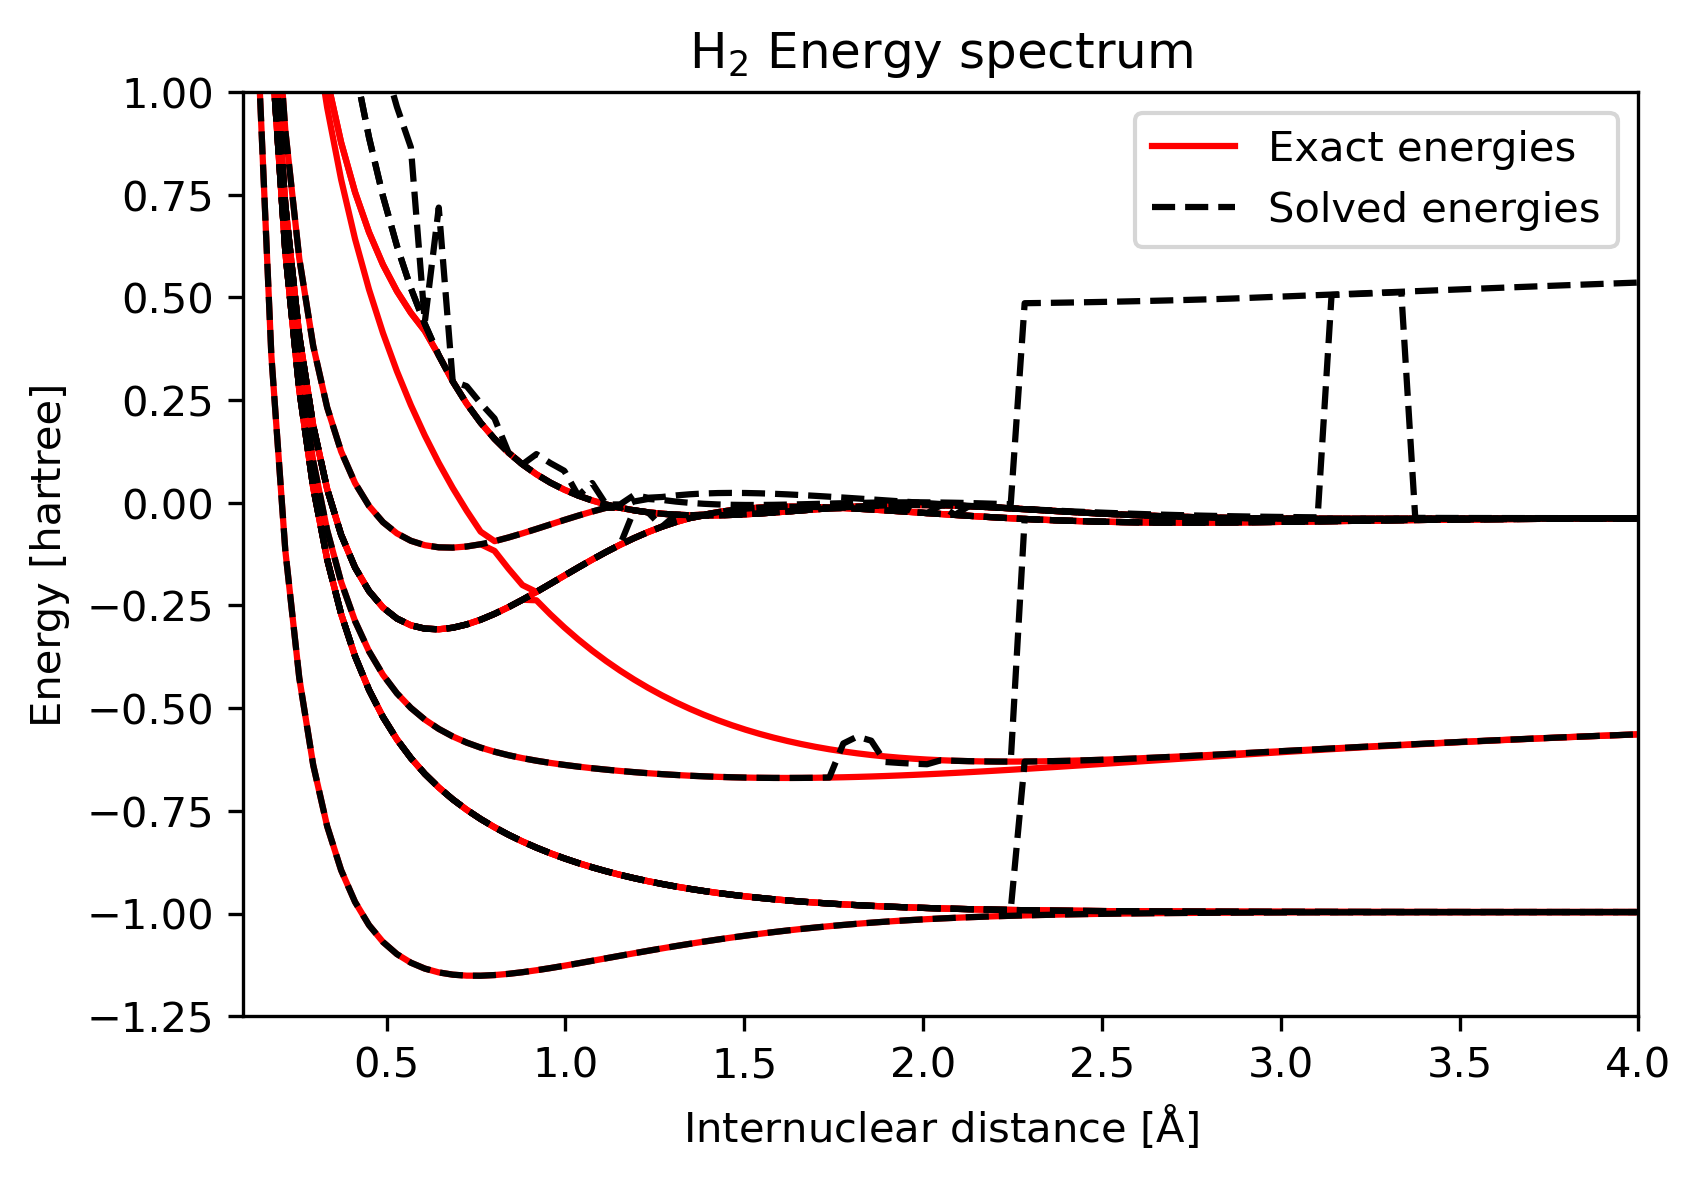

In [47]:
plt.figure(figsize=(6, 4), dpi=300)
for band in range(12):
    plt.plot(len_sweep, H_eigvals_sweep[band], 'red')
for band in range(12):
    plt.plot(len_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(len_sweep[0], H_eigvals_sweep[band][0], 'red', label='Exact energies')
plt.plot(len_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Solved energies')

plt.xlabel(r'Internuclear distance [$\mathrm{\AA}$]')
plt.ylabel('Energy [hartree]')
plt.xlim(0.1, 4)
plt.ylim(-1.25, 1)
plt.title(r'H$_2$ Energy spectrum')


plt.legend()
plt.show()

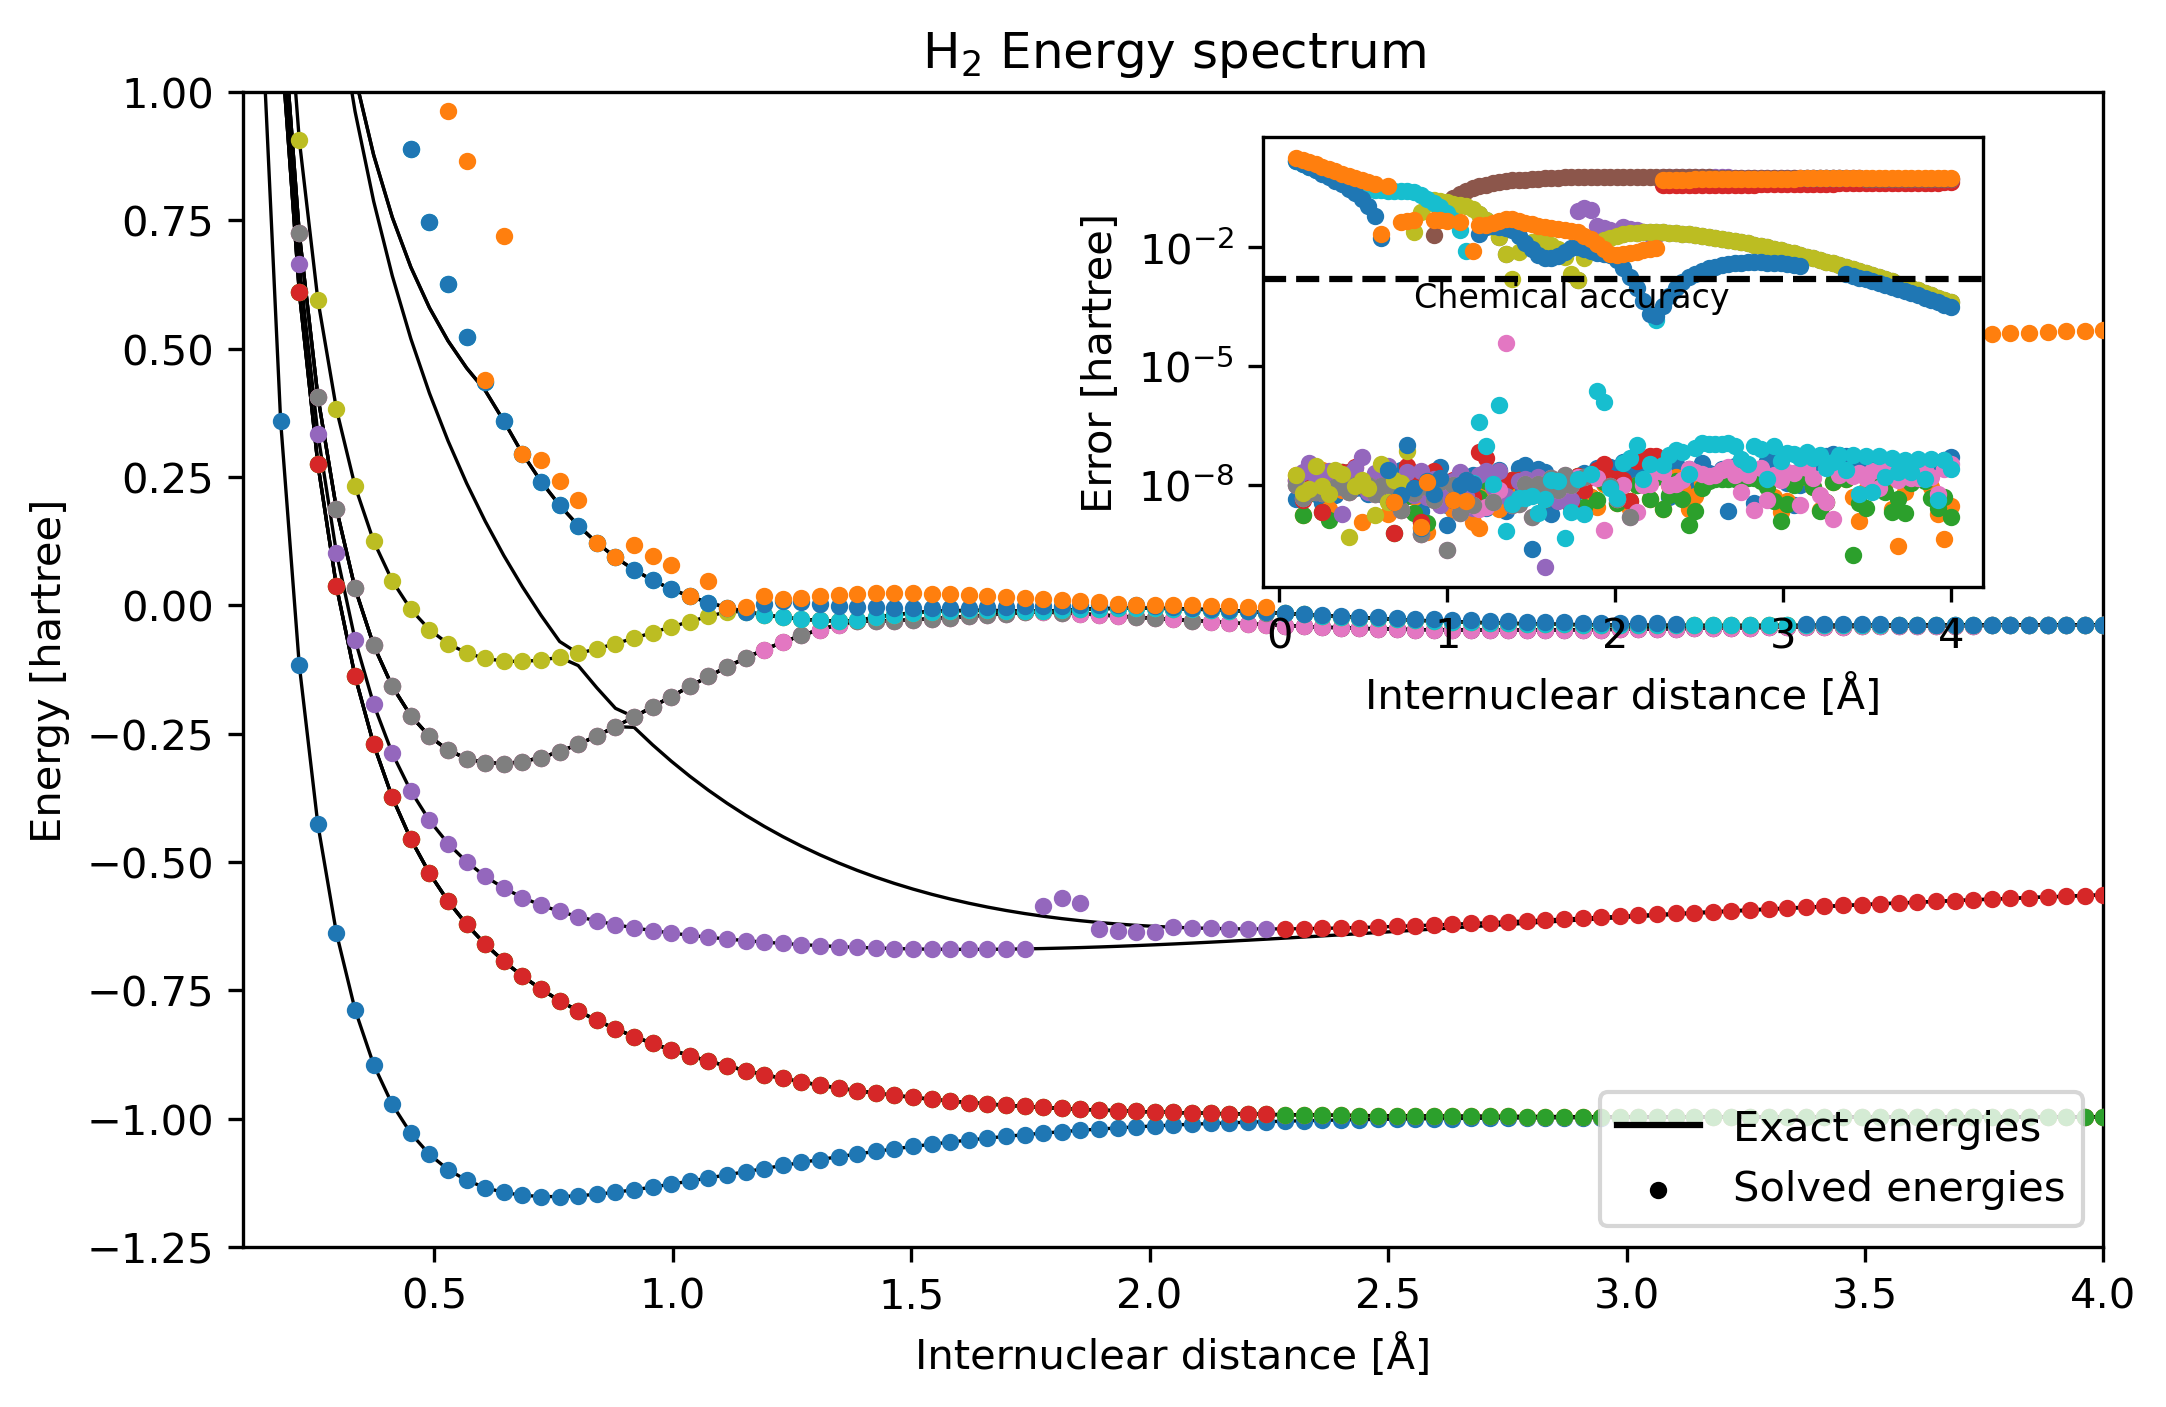

In [49]:
# plt.figure(figsize=(6, 4), dpi=300)
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
for band in range(12):
    ax.plot(len_sweep, H_eigvals_sweep[band], 'black', linewidth=0.8)

errors = np.abs(H_eigvals_sweep[:12]-solved_eigvals)

# # errors_correction
# errors_correction = []
# for point in range(7):
#     min_val = 1
#     for band in range(30):
#         if min_val > np.abs(solved_eigvals[-1][point]-H_eigvals_sweep[band][point]):
#             min_val = np.abs(solved_eigvals[-1][point]-H_eigvals_sweep[band][point])
#     errors_correction.append(min_val)

# errors[13][:7] = errors_correction
# errors[14][:7] = errors_correction
# errors[15][:7] = errors_correction

for band in range(12):
    ax.scatter(len_sweep, solved_eigvals[band], s=10, zorder=3)

ax.plot(len_sweep[0], H_eigvals_sweep[band][0], 'black', label='Exact energies')
ax.scatter(len_sweep[0], solved_eigvals[0][0], color='black', s=10, zorder=3, label='Solved energies')

# 插入誤差圖
ax_inset = fig.add_axes([0.55, 0.55, 0.3, 0.3])
for i, error in enumerate(errors):
    ax_inset.scatter(len_sweep, error, s=10)
    
ax_inset.axhline(y=1.594e-3, color='black', linestyle='dashed')  # 化學精度線
ax_inset.text(0.8, 3e-4, "Chemical accuracy", fontsize=8)
ax_inset.set_yscale("log")
ax_inset.set_xlabel("Internuclear distance [\u00c5]")
ax_inset.set_ylabel("Error [hartree]")


ax.set_xlabel('Internuclear distance [\u00c5]')
ax.set_ylabel('Energy [hartree]')
ax.set_xlim(0.1, 4)
ax.set_ylim(-1.25, 1)
ax.set_title(r'H$_2$ Energy spectrum')

ax.legend(fontsize=10, loc='lower right', frameon=True)
plt.show()